## Imports

In [1]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import pandas as pd
import scipy as scp
import numpy as np

from sklearn.mixture import GaussianMixture
from scipy.spatial import Voronoi, voronoi_plot_2d
from scipy.stats import multivariate_normal

## Functions

In [2]:
color_iter = ["saddlebrown", "teal"]

In [3]:
def plot_results(X, Y, means, covariances, title):
    plt.figure(figsize=(5,3))
    plt.scatter(X['feature1'], X['feature2'], 4, c=Y)
    for i, (mean, covar, color) in enumerate(zip(means, covariances, color_iter)): 
        v, w = scp.linalg.eigh(covar)
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
        u = w[0] / scp.linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y == i):
            continue

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180.0 * angle / np.pi  # convert to degrees
        ell = Ellipse(mean, v[0], v[1], angle=180.0 + angle, color=color)
        ell.set_clip_box(plt.subplot(1,1,1).bbox)
        ell.set_alpha(0.3)
        plt.subplot(1,1,1).add_artist(ell)
    plt.title(title)
    plt.show()

## Read dataset

In [4]:
features = [f'feature{i}' for i in range(1,31)]

In [5]:
df =  pd.read_csv('wdbc.data', sep=",", names=['id', 'label'] + features )

In [6]:
df.head()

,id,label,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,...,feature21,feature22,feature23,feature24,feature25,feature26,feature27,feature28,feature29,feature30
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [7]:
X = df.iloc[:,2:4].copy(deep=True)

In [8]:
y = df.iloc[:, [1]].copy(deep=True)

In [9]:
y['label'] = y['label'].apply(lambda x: 1 if x == "M" else 0)

array([[<AxesSubplot: title={'center': 'label'}>]], dtype=object)

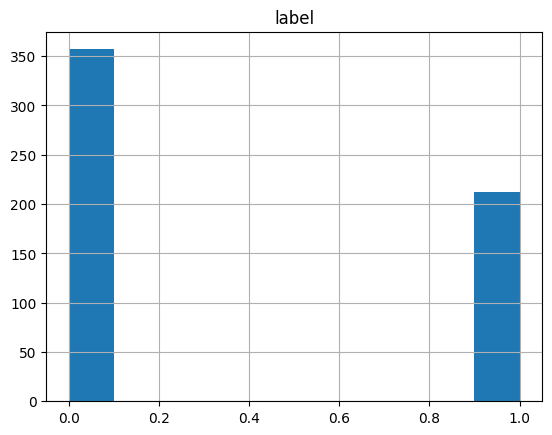

In [10]:
y.hist()

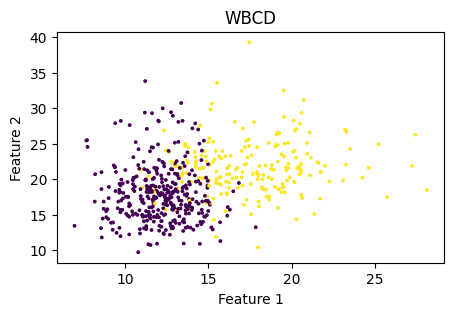

In [11]:
plt.figure(figsize=(5,3)) 
plt.scatter(X['feature1'], X['feature2'], marker='o', c=y['label'], s=3)
plt.title("WBCD")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

## sklearn EM(GMM)

In [12]:
gm = GaussianMixture(n_components=2, random_state=67)
gm_labels = gm.fit_predict(X)
centers = gm.means_

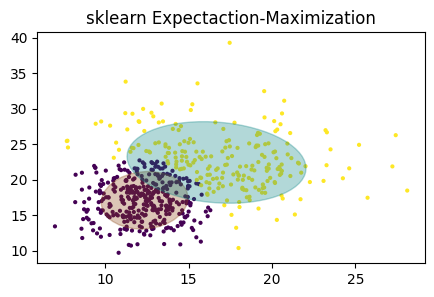

In [13]:
plot_results(X, gm_labels, gm.means_, gm.covariances_, "sklearn Expectaction-Maximization")

## My EM(GMM)

### Functions

<div class="alert alert-block alert-danger">
<b>Eroare din PDF : </b> la pasul de maximization matricea de covarianta ar trebui inmultita cu 1/Rij^k-1??
</div>

In [15]:
# Importing the libraries
import numpy as np
import pandas as pd
class MyGMM:
    '''
        This class is the implementation of the Gaussian Mixture Models 
        inspired by sci-kit learn implementation.
    '''
    def __init__(self, n_components, max_iter = 1, comp_names=None):
        '''
            This functions initializes the model by seting the following paramenters:
                :param n_components: int
                    The number of clusters in which the algorithm must split
                    the data set
                :param max_iter: int, default = 100
                    The number of iteration that the algorithm will go through to find the clusters
                :param comp_names: list of strings, default=None
                    In case it is setted as a list of string it will use to
                    name the clusters
        '''
        self.n_componets = n_components
        self.max_iter = max_iter
        if comp_names == None:
            self.comp_names = [f"comp{index}" for index in range(self.n_componets)]
        else:
            self.comp_names = comp_names
        # pi list contains the fraction of the dataset for every cluster
        self.pi = [1/self.n_componets for comp in range(self.n_componets)]

    def fit(self, X):
        '''
            The function for training the model
                :param X: 2-d numpy array
                    The data must be passed to the algorithm as 2-d array, 
                    where columns are the features and the rows are the samples
        '''
        # Spliting the data in n_componets sub-sets
        new_X = np.array_split(X, self.n_componets)
        # Initial computation of the mean-vector and covarience matrix
        self.mean_vector = [np.mean(x, axis=0) for x in new_X]
        self.covariance_matrixes = [np.cov(x.T) for x in new_X]
        # Deleting the new_X matrix because we will not need it anymore
        del new_X
        for iteration in range(self.max_iter):
            ''' --------------------------   Expectation step   -------------------------- '''
            # Initiating the r matrix, evrey row contains the probabilities
            # for every cluster for this row
            self.r = np.zeros((len(X), self.n_componets))
            # Calculating the r matrix
            for n in range(len(X)):
                for k in range(self.n_componets):
                    self.r[n][k] = self.pi[k] * multivariate_normal.pdf(X[n], self.mean_vector[k], self.covariance_matrixes[k])
                    self.r[n][k] /= sum([self.pi[j]*multivariate_normal.pdf(X[n], self.mean_vector[j], self.covariance_matrixes[j]) for j in range(self.n_componets)])
            # Calculating the N
            N = np.sum(self.r, axis=0)
            ''' --------------------------   Maximization step   -------------------------- '''
            # Initializing the mean vector as a zero vector
            self.mean_vector = np.zeros((self.n_componets, len(X[0])))
            # Updating the mean vector
            for k in range(self.n_componets):
                for n in range(len(X)):
                    self.mean_vector[k] += self.r[n][k] * X[n]
            self.mean_vector = [1/N[k]*self.mean_vector[k] for k in range(self.n_componets)]
            # Initiating the list of the covariance matrixes
            self.covariance_matrixes = [np.zeros((len(X[0]), len(X[0]))) for k in range(self.n_componets)]
            # Updating the covariance matrices
            for k in range(self.n_componets):
                self.covariance_matrixes[k] = np.cov(X.T, aweights=(self.r[:, k]), ddof=0)
            self.covariance_matrixes = [1/N[k]*self.covariance_matrixes[k] for k in range(self.n_componets)]
            # Updating the pi list
            self.pi = [N[k]/len(X) for k in range(self.n_componets)]
    def predict(self, X):
        '''
            The predicting function
                :param X: 2-d array numpy array
                    The data on which we must predict the clusters
        '''
        probas = []
        for n in range(len(X)):
            probas.append([multivariate_normal.pdf(X[n], self.mean_vector[k], self.covariance_matrixes[k])
                           for k in range(self.n_componets)])
        cluster = []
        for proba in probas:
            cluster.append(self.comp_names[proba.index(max(proba))])
        return cluster

### Implementation

In [16]:
mygmm = MyGMM(2)
mygmm.fit(X.to_numpy())
mygmm_labels = mygmm.predict(X.to_numpy())

In [17]:
mygmm_labels = [0 if i == 'comp0' else 1 for i in mygmm_labels]

In [18]:
mygmm_labels = np.array([i for i in mygmm_labels])
mygmm_mean_vector = np.array([mygmm.mean_vector[0], mygmm.mean_vector[1]])
mygmm_cov_matrixes = np.array([mygmm.covariance_matrixes[0], mygmm.covariance_matrixes[1]])

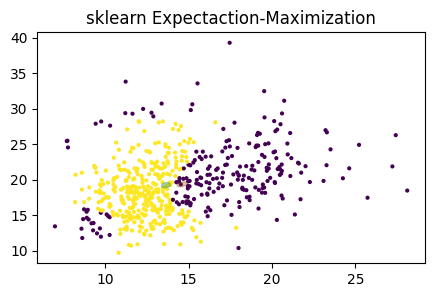

In [19]:
plot_results(X, mygmm_labels, mygmm_mean_vector, mygmm_cov_matrixes, "sklearn Expectaction-Maximization")

## Compare results

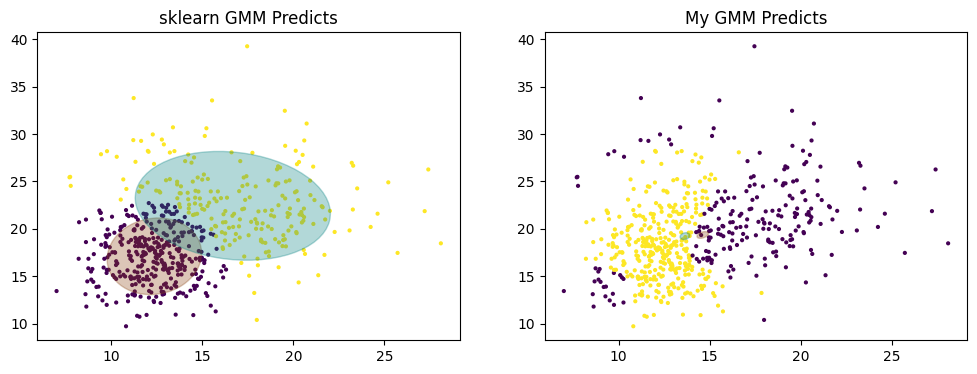

In [20]:
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.scatter(X['feature1'], X['feature2'], 4, c=gm_labels)
for i, (mean, covar, color) in enumerate(zip(gm.means_, gm.covariances_, color_iter)): 
    v, w = scp.linalg.eigh(covar)
    v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
    u = w[0] / scp.linalg.norm(w[0])
    # as the DP will not use every component it has access to
    # unless it needs it, we shouldn't plot the redundant
    # components.
    if not np.any(gm_labels == i):
        continue

    # Plot an ellipse to show the Gaussian component
    angle = np.arctan(u[1] / u[0])
    angle = 180.0 * angle / np.pi  # convert to degrees
    ell = Ellipse(mean, v[0], v[1], angle=180.0 + angle, color=color)
    ell.set_clip_box(plt.subplot(1,2,1).bbox)
    ell.set_alpha(0.3)
    plt.subplot(1,2,1).add_artist(ell)
    plt.title("sklearn GMM Predicts")
plt.subplot(1, 2, 2)
plt.scatter(X['feature1'], X['feature2'], 4, c=mygmm_labels)
for i, (mean, covar, color) in enumerate(zip(mygmm_mean_vector, mygmm_cov_matrixes, color_iter)): 
    v, w = scp.linalg.eigh(covar)
    v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
    u = w[0] / scp.linalg.norm(w[0])
    # as the DP will not use every component it has access to
    # unless it needs it, we shouldn't plot the redundant
    # components.
    if not np.any(mygmm_labels == i):
        continue

    # Plot an ellipse to show the Gaussian component
    angle = np.arctan(u[1] / u[0])
    angle = 180.0 * angle / np.pi  # convert to degrees
    ell = Ellipse(mean, v[0], v[1], angle=180.0 + angle, color=color)
    ell.set_clip_box(plt.subplot(1,2,2).bbox)
    ell.set_alpha(0.3)
    plt.subplot(1,2,2).add_artist(ell)
    plt.title("My GMM Predicts")
plt.show()